# Comparison of resolution in Star460L vs Star635P channels
 <br>
 
  
  
---



<br>


| Date started | Date completed | Experiments treated | Comments |
|:---|:---|:---|:----|
|30/08/2022|  | 220829| mAb414 primary antibody<br>secondary antibodies (simultaneous) anti-mouse Star460L Star635P<br>detection of pores<br>fitting with a single Gaussian<br>extraction and comparison of the FWHM|

<br>

----

## Goal and workflow

The goal is to 
- standardize and pre-process images to attenuate variations in acquisition
- automatically establish a mask to remove areas outside nuclei
- extract NPC coordinates based on mAb414 labelling - thresholds are calculated automatically (otsu threshold)
- fit NPC with a Gaussian
- extract FWHM
- compile all data in a DataFrame that contains all this info:
        - file name
        - condition (labeling)
        - NPC coordinates
        - channel
        - fitting parameters (FWHM, amplitude...)
        - thresholds






---

## Table of content

* [Import libraries](#libraries)
* [Detect pores](#detection)
    * [Load and parametrize data]
    * [Pre-process images]
    * [Detect NPCs]
    * [Store and save pore coordinates]
* [Analyze NPCs](#analysis)
    * [Trace intensity profiles at each pore coordinate]
    * [Fit intensity profile with 1 or 2 Gaussian]
    * [Extract the fit parameters]
* [Compile and save data](#table)
* [Graphical comparison of the resolution in the two channels](#fit_data)
* [Material and Methods](#methods)



---

## Import libraries <a class="anchor" id="libraries"></a>



In [1]:
# Import packages
import os
import glob
#import json
from tkinter.filedialog import askdirectory
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage import morphology
from skimage.feature import peak_local_max
import skimage.filters as skfilt
from scipy import ndimage as ndi
from scipy import ndimage
import skimage.filters
from skimage.filters import threshold_otsu
import plotly.express as px



from clustersize import cluster_size
from findmaxima import find_maxima
from binarycellmap import binary_cell_map
from iterative_functions import lorentzian, gaussian, iterative_fit

---

## Detect pore intermediates <a class="anchor" id="detection"></a>




In [11]:
## Load data and parameters 
#Choose the data folder
dirpath = askdirectory(title='Choose your data folder...',initialdir='/Users/christine/Documents/Data/STED/')  # directory path
print(dirpath)
outputpath = askdirectory(title='Choose the folder to save your results...',initialdir='/Users/christine/Documents/Data/STED/')
print(outputpath)


/Users/christine/Documents/Data/STED/220829/Data_3C_mAb414
/Users/christine/Documents/Data/STED/220829/Data_3C_mAb414/Results


In [12]:
## Define parameter constants

difgaus_sigmahi_nm = 100  # difference of gaussians high_sigma in nm
sm_size_nm = 30  # Gaussian size in nm for pore detection
gf_nm = 10 # Gaussian size in nm for denoising

minpeakdist = 40  # minimum distance between peaks in nm for peak detection 
  


In [13]:
allimgs = True  # parameter to check if you want to loop through all imgs or just analyse one


## Load images paths
if allimgs:
    files = glob.glob(os.path.join(dirpath, '*[0-9].tif'))
    
else:
    files = [os.path.join(dirpath, 'IF_Cells_U20S_fixed_Nup96-GFP_mAb414-A594(200)-Star635P-1.tif')]

    

IF_Cells_U20S_fixed_Nup96-GFP_mAb414-A594(200)-Star635P-3
px size=  15.00000037500001


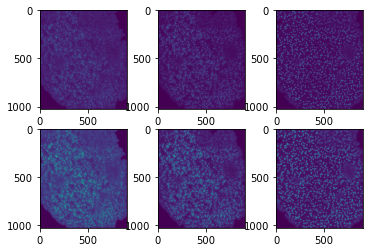

IF_Cells_U20S_fixed_Nup96-GFP_mAb414-A594(200)-Star635P-2
px size=  15.00000037500001


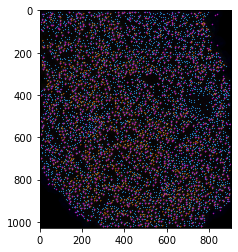

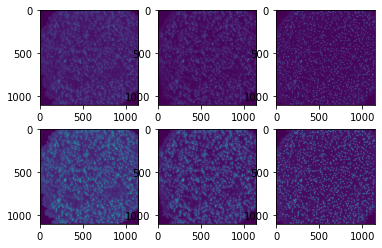

IF_Cells_U20S_fixed_Nup96-GFP_mAb414-A594(200)-Star635P-1
px size=  15.00000037500001


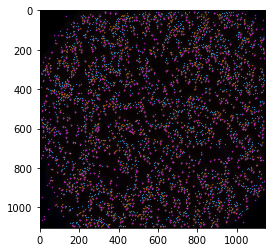

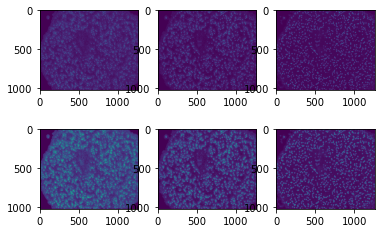

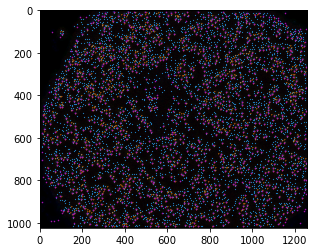

In [17]:
## define function to pre-process images

def preProcess(Im,gf_nm,pxs_nm):
    Imstd = (Im-np.min(Im))/(np.max(Im)-np.min(Im))
    Imsmoothed = ndimage.filters.gaussian_filter(Imstd, sigma=gf_nm/pxs_nm)
    mask = binary_cell_map(Imsmoothed, pxs_nm=pxs_nm)
    BW = mask     
    Im_norm = (Imsmoothed*BW)#.astype(np.uint8)

    return Im_norm,BW


## define function to detect pores

def detect(Im,mask,minpeakdist,pxs_nm):
    Th = threshold_otsu(Im)-0.5*np.std(Im, where=mask) 
    peaks = find_maxima(Im, thresh_abs=Th, min_dist=round(minpeakdist/pxs_nm))
    
    return peaks



######################################################################################################################

pores = [] 

## Extract image names from paths
for filepath in files:
    imgname = filepath.split('/')[-1].split('.')[0]
    print(imgname)
    #condition = imgname.split('_')[-1].split('-')[0]
    
    # Load raw image file and read pixel size from metadata
    S460path = os.path.join(dirpath, imgname+'.msr_460L.tif')
    S580path = os.path.join(dirpath, imgname+'.msr_580.tif')
    S635path = os.path.join(dirpath, imgname+'.msr_635P.tif')
    
    
    with tifffile.TiffFile(S460path) as tif:
        S460raw = tif.pages[0].asarray()  # image as numpy array
        pxs_nm = 1e9/tif.pages[0].tags['XResolution'].value[0]  # pixel size in nm
        print('px size= ',pxs_nm)
        
    with tifffile.TiffFile(S580path) as tif:
        S580raw = tif.pages[0].asarray()  # image as numpy array
    
    with tifffile.TiffFile(S635path) as tif:
        S635raw = tif.pages[0].asarray()  # image as numpy array
        
    
        
######################################################################################################################
## Pre-process images 

    S460_norm,BW460 = preProcess(S460raw,gf_nm,pxs_nm)
    S580_norm,BW580 = preProcess(S580raw,gf_nm,pxs_nm)
    S635_norm,BW635 = preProcess(S635raw,gf_nm,pxs_nm)
    
    
    ## Apply a gaussian filter
    S460filt = ndimage.filters.gaussian_filter(S460_norm, sigma=sm_size_nm/pxs_nm)
    S580filt = ndimage.filters.gaussian_filter(S580_norm, sigma=sm_size_nm/pxs_nm)
    S635filt = ndimage.filters.gaussian_filter(S635_norm, sigma=sm_size_nm/pxs_nm)
    

    
    fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(nrows=2,ncols=3)
    ax0.imshow(S460_norm)
    ax1.imshow(S580_norm)
    ax2.imshow(S635_norm)
    ax3.imshow(S460filt)
    ax4.imshow(S580filt)
    ax5.imshow(S635filt)
    plt.show()
    
######################################################################################################################
## Detect pores 


## Build RGB image for visual verification
    
    RGB = np.dstack((S460_norm,S580_norm,S635_norm))#.astype(np.uint8)
    fig, ax = plt.subplots()
    plt.imshow(RGB)
    
    
## Detect peaks in the three channels
    peaks460 = detect(S460filt,BW460,minpeakdist,pxs_nm)
    peaks580 = detect(S580filt,BW580,minpeakdist,pxs_nm)
    peaks635 = detect(S635filt,BW635,minpeakdist,pxs_nm)
    
    ax.scatter(peaks460[:, 1], peaks460[:, 0], s=1,marker='x',edgecolors='y',linewidths=0.5)
    ax.scatter(peaks580[:, 1], peaks580[:, 0], s=1,marker='+',edgecolors='c',linewidths=0.5)
    ax.scatter(peaks635[:, 1], peaks635[:, 0], s=1,marker='o',edgecolors='m',linewidths=0.5)
    
    plt.savefig(outputpath+'/'+imgname+'_peaks.tif',dpi=600)
    
    
    
    
    
 


In [ ]:
## Sort out PIs    
    fig, ax = plt.subplots()
    plt.imshow(RGB,vmin=0, vmax=20)
    
    
    pint=0
    npc=0

    N=len(POM_peaks)
    print(N)
    for i in range(0,N):
        x = round(POM_peaks[i,0])
        y = round(POM_peaks[i,1])
        #print(POM_peaks[i,0],x,POM_peaks[i,1],y,POMimg[x,y])
        if mABimg[x,y]<ThmAB:
            status='PI'
            pores.append([imgname, condition, pxs_nm, ThPOM, ThmAB,x, y,status])
            ax.scatter(y,x,s=1,marker='x',c='c',linewidths=0.5)
            pint = pint+1
        #else:
            #status='NPC'
            #pores.append([imgname, condition, pxs_nm, ThPOM, ThmAB,x, y,status])
            #ax.scatter(y,x,s=2,marker='+',c='c',linewidths=0.5)
            #npc = npc+1
    for j in range(0,len(mAB_peaks)):
        x = round(mAB_peaks[j,0])
        y = round(mAB_peaks[j,1])
        status='NPC'
        pores.append([imgname, condition, pxs_nm, ThPOM, ThmAB,x, y,status])
        ax.scatter(y,x,s=2,marker='+',c='y',linewidths=0.5)
        npc = npc+1
        
        
    plt.savefig(outputpath+'/'+imgname+'_pores.tif',dpi=600)
    plt.show()
    print(pint,npc)
    
pores = pd.DataFrame(pores, columns=['Filename','Condition','px (nm)', 'ThPOM','ThmAB','x', 'y','Pore status'])   
pores


pores.to_csv(outputpath+'/pores.csv')


---

## Analyze pore intermediates <a class="anchor" id="analysis"></a>



In [ ]:
from skimage.measure import profile_line
from skimage import io

## Setup parameters for line profiles
L = 150 # length of the line in nm
gf_nm = 10 # sigma in nm for the Gaussian filter

## Load data
pores = pd.read_csv(outputpath+'/pores.csv', sep=',')
pores


In [ ]:
#### Scan pore coordinates and images
prev_col = pores.columns
data=[]

images = np.unique(pores['Filename'])

for j in range(0,len(images)):
    imgname = images[j]
    print(imgname)
    
    ## load and filter POM121 and mAB414 channels
    POMraw = io.imread(dirpath+'/'+imgname+'.msr_POM.tif', as_gray=True)
    mABraw = io.imread(dirpath+'/'+imgname+'.msr_414.tif', as_gray=True)
    POMstd = (POMraw-np.min(POMraw))/(np.max(POMraw)-np.min(POMraw))
    POMstd = ndimage.filters.gaussian_filter(POMstd, sigma=gf_nm/pxs_nm)
    mABstd = (mABraw-np.min(mABraw))/(np.max(mABraw)-np.min(mABraw))
    mABstd = ndimage.filters.gaussian_filter(mABstd, sigma=gf_nm/pxs_nm)
    B = np.zeros(POMstd.shape)
    RGB = np.dstack((mABstd,POMstd,B))

    
    pores_j=pores[pores['Filename']==imgname]
    
    for i in range(0,len(pores_j)): 
        print(i)
        prev_data=pores_j.iloc[i,:].values      

        ## length of the line in px
        pxs_nm = pores_j.iloc[i,3]
        l = (L/pxs_nm)/2     

        ## coordinates of pore centers
        xo = pores_j.iloc[i,6]
        yo = pores_j.iloc[i,7]

    #### Trace rotationally averaged intensity profiles

        ## Rotate the line and define its extremities
        POMprof_a=[]
        mABprof_a=[]
        
        for a in range(0,171,9):

            src = xo-l*np.cos(a), yo-l*np.sin(a)
            dst = xo+l*np.cos(a), yo+l*np.sin(a)
            
            y_p = profile_line(POMstd,src,dst,order=2,mode='constant',cval=0)
            y_m = profile_line(mABstd,src,dst,order=2,mode='constant',cval=0)
            

            POMprof_a.append(y_p)
            mABprof_a.append(y_m)


        POMprof_i = np.mean(POMprof_a, axis=0)
        mABprof_i = np.mean(mABprof_a, axis=0)

        centers=np.linspace(-L/2,L/2,len(POMprof_i))
        x=np.linspace(-L/2,L/2,120)


    #### POM121 channel

        channel = 'POM121'

    #### Fit pore profile with 1 or 2 Lorentzian
        f = lorentzian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,POMprof_i,nb_iterations=2)
        
        except RuntimeError:
            pass
        new_data=[channel,centers,POMprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])
    
#### Fit pore profile with 1 or 2 Gaussians
        f = gaussian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,POMprof_i,nb_iterations=2)
        except RuntimeError:
            pass
        
        new_data=[channel,centers,POMprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])

    #### mAb414 channel

        channel = 'mAb414'

    #### Fit pore profile with 1 or 2 Lorentzian
        f = lorentzian
        try: 
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,mABprof_i,nb_iterations=2)
        #ax0.plot(x,f(x, *popt),c='c', linestyle='--')
        #print(f, n,r_sq)
        except RuntimeError:
            pass
        new_data=[channel,centers,mABprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])

    #### Fit pore profile with 1 or 2 Gaussians
        f = gaussian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,mABprof_i,nb_iterations=2)
        
        except RuntimeError:
            pass
        new_data=[channel,centers,mABprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])
    
new_col = ['Channel','Centers (nm)','Intensity','Function','nb iterations','R2','*popt']   
col=[*prev_col,*new_col]
df=pd.DataFrame(data,columns=col)
df

df.to_csv(outputpath+'/pore_analysis.csv', sep=';')

    

---

## Compile and save data <a class="anchor" id="table"></a>



In [ ]:
new_col = ['Channel','Centers (nm)','Intensity','Function','nb iterations','R2','*popt']   
col=[*prev_col,*new_col]
df=pd.DataFrame(data,columns=col)
df

df.to_csv(outputpath+'/pore_analysis.csv', sep=';')

---

## Diving into the fit data <a class='anchor' id='fit_data'></a>



In [ ]:
import seaborn as sns

data = pd.read_csv(outputpath+'/pore_analysis.csv', sep=';')
data


In [ ]:
from scipy.stats import stats

data_POM = data[data['Channel']=='POM121']
data_mAB = data[data['Channel']=='mAb414']
data_mAB_NPC = data_mAB[data_mAB['Pore status']=='NPC']
data_POM_PI = data_POM[data_POM['Pore status']=='PI']
print(len(data_PI))
print(len(data))
#### 
## calculate p-values
mAB_NPC_g = data_mAB_NPC[data_mAB_NPC['Function']=='<function gaussian at 0x7ffd10ad0820>']['R2']
mAB_NPC_l = data_mAB_NPC[data_mAB_NPC['Function']=='<function lorentzian at 0x7ffd10ad0700>']['R2']
p1 = stats.ttest_ind(mAB_NPC_g,mAB_NPC_l, equal_var=True)
print(p1)

POM_PI_g = data_POM_PI[data_POM_PI['Function']=='<function gaussian at 0x7ffd10ad0820>']['R2']
POM_PI_l = data_POM_PI[data_POM_PI['Function']=='<function lorentzian at 0x7ffd10ad0700>']['R2']
print(np.mean(POM_PI_l),np.mean(POM_PI_g))
p2 = stats.ttest_ind(POM_PI_g,POM_PI_l, equal_var=True)
print(p2)

fig,ax0 = plt.subplots()
fig.suptitle('Channel = mAb414 - NPCs', fontsize=20)
sns.violinplot(x=data_mAB_NPC['Function'], y=data_mAB_NPC['R2'], area='counts', ax=ax0)
#sns.swarmplot(x=data['Channel'], y=data['nb iterations'],hue=data['Pore status'], dodge=True, ax=ax0)
ax0.set_ylim([0.8,1.2])
ax0.set_ylabel('R2',fontsize=16)
ax0.set_xlabel('Function',fontsize=16)


fig,ax1 = plt.subplots()
fig.suptitle('Channel = POM121 - PIs', fontsize=20)
sns.violinplot(x=data_POM_PI['Function'], y=data_POM_PI['R2'], area='counts', ax=ax1)
#sns.swarmplot(x=data['Channel'], y=data['nb iterations'],hue=data['Pore status'], dodge=True, ax=ax0)
ax1.set_ylim([0.8,1.2])
ax1.set_ylabel('R2',fontsize=16)
ax1.set_xlabel('Function',fontsize=16)


data_g=data[data['Function']=='<function gaussian at 0x7ffd10ad0820>']
data_good=data_g[data_g['R2']>=0.95]
fig,ax2 = plt.subplots()
fig.suptitle('Nb of peaks', fontsize=20)
sns.violinplot(x=data_g['Channel'], y=data_g['nb iterations'], hue=data_g['Pore status'],area='counts', ax=ax2)
#sns.swarmplot(x=data['Channel'], y=data['nb iterations'],hue=data['Pore status'], dodge=True, ax=ax0)

ax2.set_ylabel('nb iterations',fontsize=16)
ax2.set_xlabel('Channel',fontsize=16)


fig,ax3 = plt.subplots()
fig.suptitle('Nb of peaks - well fitted data only', fontsize=20)
sns.violinplot(x=data_good['Channel'], y=data_good['nb iterations'], hue=data_good['Pore status'],area='counts', ax=ax3)
#sns.swarmplot(x=data['Channel'], y=data['nb iterations'],hue=data['Pore status'], dodge=True, ax=ax0)

ax3.set_ylabel('nb iterations',fontsize=16)
ax3.set_xlabel('Channel',fontsize=16)

fig,ax4 = plt.subplots()
fig.suptitle('R2', fontsize=20)
#sns.violinplot(x=data['Channel'], y=data['R2'], hue=data['Pore status'],area='counts', ax=ax4)
sns.boxplot(x=data['Channel'], y=data['R2'], hue=data['Pore status'], fliersize=2,ax=ax4)
ax4.hlines(0.95, -0.8,1.8,color='red',linestyles='--')

#sns.swarmplot(x=data['Channel'], y=data['nb iterations'],hue=data['Pore status'], dodge=True, ax=ax0)

ax4.set_ylabel('R2',fontsize=16)
ax4.set_xlabel('Channel',fontsize=16)

plt.show()




In [ ]:

pores=pd.read_csv(outputpath+'/pores.csv')
pores
images = np.unique(pores['Filename'])
percent=[]
for j in range(0,len(images)):
    pores_j=pores[pores['Filename']==images[j]]
    pores_j_PI=pores_j[pores_j['Pore status']=='PI']
    
    nb_PI_j=len(pores_j_PI)
    
    
    nb_tot_j = len(pores_j) 
    percent_PI_j = nb_PI_j/nb_tot_j
    percent.append([images[j],percent_PI_j])
    
df=pd.DataFrame(percent)
df
  


### Conclusions

- For mAB414 signal (NPCs) gaussians seem to fit better than Lorentzian with a significant p-value (10<sup>-164</sup>).
- For POM121 PIs, gaussian fitting performs slightly better (R2=0.9833 vs 0.9794) with a significant p-value (10<sup>-8</sup>).
- fits are excellent for POM121 PI and mAb414 NPCs. it is expected that mAb414 PI fit very badly since there is by definition hardly any signal. However, if we want to extract information from POM121 NPCs, we need to apropriately sort the data.





-----

## Material and methods <a class="anchor" id="methods"></a>

### Pore detection

Images of the POM121 and mAb414 channels were filtered with a Gaussian filter (sigma = 30nm). As a result, the annular POM121 signal is merged into a single bell-shaped spot. Thresholds for the POM121 and mAb414 signals are calculated via the Otsu method. Local maxima are detected on the POM121 image, with a threshold set to the Otsu threshold - 0.4* the image standard deviation. Peaks within a distance of 40nm are merged. the peaks coordinates are stored and sorted into "pore intermediates" or "mature NPCs", based on their mAB414 level. The threshold to discriminate between these two classes is set to the mAb414 Otsu threshold - 1.5* the standard deviation of the mAb414 image. Results were visually inspected and validated.

### Size determination and distribution




